<a href="https://colab.research.google.com/github/KatherineElkins/programming-humanity-2025/blob/main/model_wealth_powerlaw_112025_FIXED3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Author: Katherine Elkins
## 18 Nov 2025

<a href="https://colab.research.google.com/github/your-org/your-repo/blob/main/model_wealth_powerlaw_112025.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Wealth Distribution with Agent-Based Simulation (Mesa)

This notebook is designed for an **undergraduate CS / AI class**, including students with **little or no math background**.

You'll use the [`mesa`](https://mesa.readthedocs.io/) agent-based modeling library to simulate a tiny “toy economy” where people randomly give each other coins.

---

### Big-picture, non-technical story

Imagine a party where:

* There are **N people** in a room.
* Everyone starts with **1 coin**.
* Every “tick” of time, each person (in random order):
  * If they have at least 1 coin, **gives 1 coin** to some random person in the room.

No one is “smarter” or “more hard-working” in this story. The **only** rule is random giving.

Yet over time, the coins **clump**: a few people end up holding many coins, and many people end up with very few.  
This is a simple way to see how **inequality can emerge from randomness**.

---

### Learning goals

By the end, you should be able to:

* Describe the basic components of an **agent-based model** (agents, model, activation).
* Read and modify a **Python implementation** of a simple wealth-exchange model using Mesa.
* Interpret plots of the resulting **wealth distribution** (who has how much money) and relate them to heavy-tailed / power-law–like behavior.
* Explore how changing parameters (number of agents, how long we run, etc.) changes the outcome.


## 1. Environment setup (Colab vs local)

In **Colab**, you usually need to install Mesa (and sometimes update `ipywidgets`).  
If you're running locally and already installed Mesa, you can skip the next cell.

**What the next code cell does**

* Installs the latest Mesa 3.x version.
* Ensures `seaborn` (for nicer plots), `ipywidgets` (for sliders), and `tqdm` (for a progress bar) are available.
* Enables a custom widget manager in Colab so the sliders and progress bars show correctly.

> 💻 **About CPU vs GPU (T4)**  
> This notebook uses standard Python loops on the **CPU**. A GPU **usually does NOT speed this up**.  
> What matters much more is:
>
> * How many agents you use (`pop`)
> * How many steps you run (`steps`)
>
> If your notebook feels slow:
>
> 1. **First**, try smaller values for `pop` and `steps` (e.g. `pop=3000`, `steps=1000`).
> 2. Only if you still have trouble: switch Colab to a GPU T4 runtime:
>    * Menu: **Runtime → Change runtime type**
>    * Hardware accelerator: **GPU**
>    * (Colab will usually give you a T4 or similar card)
>
> Even then, don’t expect a huge speed-up for this specific model; Python is still the main bottleneck.


In [ ]:
# If you're in Google Colab, run this once.
# If you're on your own machine and already installed these, you can skip.

!pip install -q "mesa>=3.0.0" seaborn ipywidgets tqdm

# In some Colab environments, widgets need this line to display correctly:
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except Exception:
    pass

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.9/239.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


## 2. Defining the wealth-exchange model (Mesa 3 style)

We will implement the “party with coins” story as an **agent-based model**:

* There are **N agents** (people).
* Everyone starts with **1 unit of wealth**.
* At each step:
  * Agents are activated in **random order**.
  * If an agent has at least 1 unit of wealth, it **gives 1 unit** to a randomly chosen other agent.

Over many steps, this simple random rule produces a **skewed wealth distribution**:  
many agents are poor, and a few are rich, even though everyone is following the same rule.

---

### Mesa 3 concepts used here

Mesa 3 changed how we manage agents and activation:

* `mesa.Agent` – base class for individual agents.
* `mesa.Model` – base class for the overall model.
* `model.agents` – an **AgentSet** containing all agents in the model.
* `self.agents.shuffle_do("step")` – activates all agents in **random order**, calling their `.step()` methods.

So instead of using an external scheduler like `mesa.time.RandomActivation`, we now rely on the built-in `AgentSet` API.

---

### Intuition

* Think of each agent as a **little story character** that only knows:
  * “Do I have at least 1 coin?”
  * “If yes, I pick someone at random and give them 1 coin.”
* The **model** is like the “director” that:
  * Keeps track of all the agents.
  * Tells them when to act (“it’s your turn to step”).

We don’t write down equations ourselves; instead we **simulate** lots of small random interactions and see what happens.

---

### Self-study / exploration

1. Modify the agent so that it sometimes **takes** money instead of always giving it away.  
2. Add a simple **tax / redistribution** rule: each step, a small fraction of everyone’s wealth is collected and evenly redistributed.


In [ ]:
import mesa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from tqdm.notebook import tqdm  # progress bar

sns.set()  # nicer default plots


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth (Mesa 3 idiom)."""

    def __init__(self, model: mesa.Model, wealth_init: int = 1):
        # Mesa 3: pass *only* the model to super().__init__
        super().__init__(model)
        self.wealth = int(wealth_init)

    def step(self):
        """Give 1 unit of wealth to a random other agent, if possible."""
        if self.wealth <= 0:
            return

        # model.agents is an AgentSet; .random is Mesa's RNG
        other = self.random.choice(self.model.agents)
        other.wealth += 1
        self.wealth -= 1


class MoneyModel(mesa.Model):
    """Simple random-exchange wealth model using Mesa 3 AgentSet API."""

    def __init__(self, N: int, seed: int | None = None):
        # Initialize Mesa model with optional random seed
        super().__init__(seed=seed)
        self.num_agents = int(N)

        if self.num_agents < 1:
            raise ValueError("N must be at least 1.")

        # Mesa 3 convenience: create N agents and auto-register them
        MoneyAgent.create_agents(self, n=self.num_agents, wealth_init=1)

    def step(self):
        """Advance the model by one time step."""
        # Activate all agents in random order
        self.agents.shuffle_do("step")

## 3. Running the model and plotting the wealth distribution

We will wrap the model in a helper function `run_money_model` that:

1. Builds a `MoneyModel` with a given population size `pop`.
2. Runs it for `steps` iterations.
3. Collects the final wealth of all agents.
4. Plots a **histogram** (optionally on a log x-axis).

We then connect this function to an `ipywidgets.interact` widget so you can explore the model interactively.

---

### What the sliders mean

* `pop` – **population size**: how many agents (people) are in the model.  
  *More agents → more total coins → richer structure in the histogram, but also slower runs.*

* `steps` – how long we let the model run.  
  *More steps → more time for inequality to develop, but again slower runs.*

* `bins` – how many “buckets” we use in the histogram.  
  *More bins → more detail, but if there are too many bins and not enough data, the plot can look noisy.*

* `log_x` – whether to use a **logarithmic x-axis** for wealth.  
  This stretches out the right-hand “tail” where very rich agents live, making it easier to see heavy-tailed behavior.

---

### How to interpret the histogram (non-STEM intuition)

Think of the histogram as answering: **“How many people have this many coins?”**

* The x-axis is **wealth** (number of coins).
* The y-axis is roughly **“how common”** that level of wealth is (density).

If most of the bars are near small wealth values, but there are a few bars far out to the right, that means:

* **Most people are poor.**
* A **small number** of people are very rich.

If you turn on `log_x`, those few very rich agents become easier to see, because the scale stretches out the upper values.

---

### Performance and progress bar

To keep things responsive in the typical Colab CPU runtime:

* The **default settings** (`pop=3000`, `steps=1000`) should finish in well under a minute on CPU.
* The **maximum slider values** are chosen so that even the heaviest run should finish in under 1–2 minutes on a T4-level CPU/GPU runtime.

While the model runs, you’ll see a **progress bar** labeled “Simulating”, so you know it hasn’t frozen.

---

### Self-study / exploration

* Add a **Gini coefficient** function and track how inequality evolves as a function of `steps`.
* Try plotting the **CDF** (cumulative distribution function): the fraction of agents with wealth **less than or equal** to a given value.


In [ ]:
def run_money_model(pop: int = 200, steps: int = 500, log_x: bool = False, bins: int = 50):
    """Run the money model and plot the resulting wealth distribution.

    Parameters
    ----------
    pop : int
        Number of agents in the model (population size).
    steps : int
        Number of model steps to run.
    log_x : bool
        If True, use a logarithmic x-axis (helpful for heavy tails / power-law-like behavior).
    bins : int
        Number of bins in the histogram.
    """
    pop = int(pop)
    steps = int(steps)
    bins = int(bins)

    if pop < 1:
        raise ValueError("Population must be at least 1.")
    if steps < 0:
        raise ValueError("Steps must be non-negative.")

    model = MoneyModel(pop)

    # Progress bar so students can see that the model is running
    for _ in tqdm(range(steps), desc="Simulating", leave=False):
        model.step()

    # Extract wealth data from all agents
    wealth = np.array([agent.wealth for agent in model.agents])

    plt.figure(figsize=(8, 5))
    sns.histplot(wealth, bins=bins, stat="density", kde=False)
    if log_x:
        plt.xscale("log")
    plt.xlabel("Wealth (number of coins)")
    plt.ylabel("Density (how common)")
    plt.title(f"Wealth distribution (N={pop}, steps={steps})")
    plt.tight_layout()
    plt.show()


# # Interactive widget for exploration (A bit flakey, make explicit calls to run_money_model() below)
# interact(
#     run_money_model,
#     # run_money_model(pop=300, steps=500, log_x=False, bins=50),
#     pop=(100, 2000, 100),       # population slider: 100 .. 10,000
#     steps=(0, 1000, 50),         # steps slider: 0 .. 3,000
#     log_x=False,
#     bins=(10, 200, 10),
# );

Simulating:   0%|          | 0/500 [00:00<?, ?it/s]

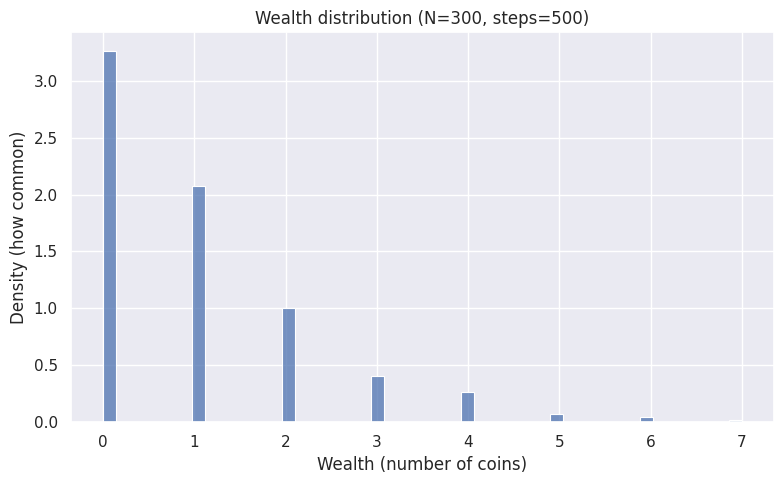

In [ ]:
run_money_model(pop=300, steps=500, log_x=False, bins=50)

Simulating:   0%|          | 0/5 [00:00<?, ?it/s]

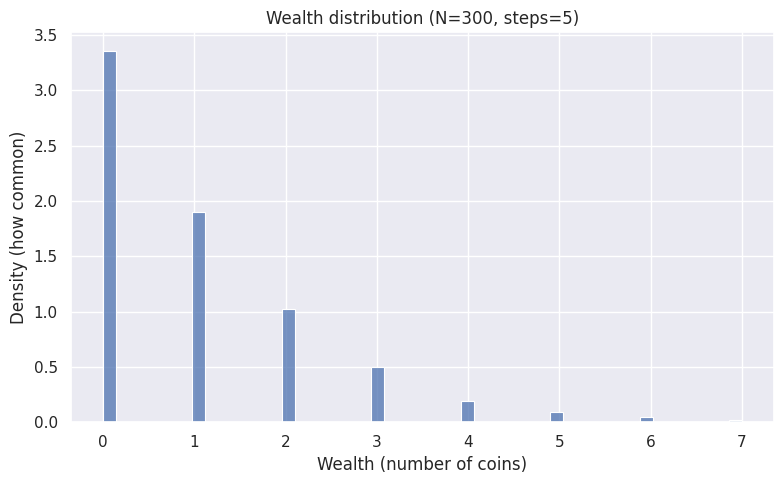

In [ ]:
run_money_model(pop=300, steps=5, log_x=False, bins=50)

Simulating:   0%|          | 0/5000 [00:00<?, ?it/s]

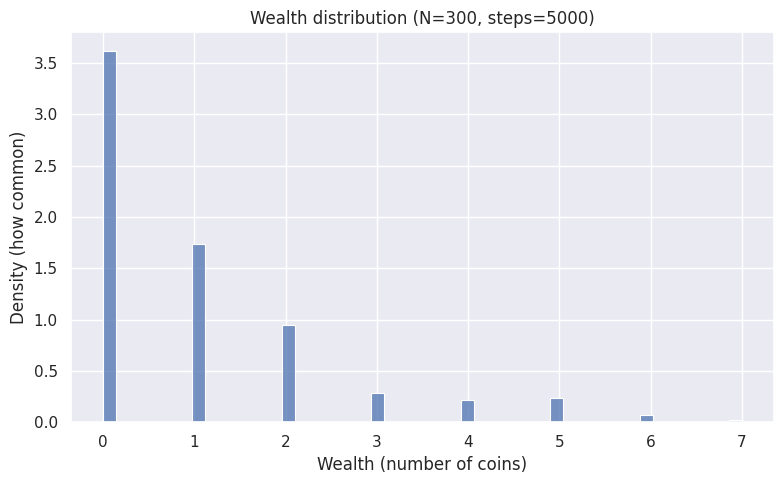

In [ ]:
run_money_model(pop=300, steps=5000, log_x=False, bins=50)

Simulating:   0%|          | 0/1 [00:00<?, ?it/s]

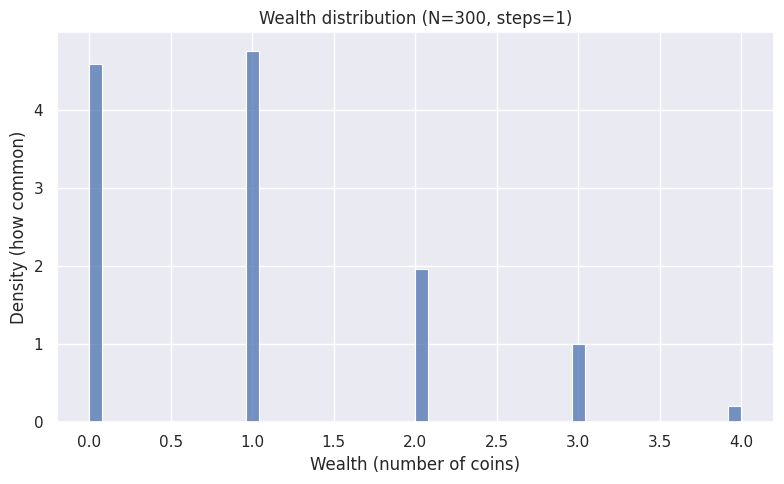

In [ ]:
run_money_model(pop=300, steps=1, log_x=False, bins=50)

## 4. Further questions & extensions (for homework or projects)

Here are some ideas you can assign as **short exercises** or **mini-projects**:

1. **Saving propensity**  
   Modify the model so that each agent keeps a fixed fraction `s` of their wealth and only risks the remaining fraction in exchanges.  
   *How does increasing `s` change the shape of the wealth distribution?*

2. **Tax and redistribution**  
   Add a simple tax rule: every `k` steps, collect a small tax from each agent and redistribute it equally.  
   *What happens to inequality measures (e.g., Gini)?*

3. **Heterogeneous agents**  
   Give each agent a different probability of being selected to give money (wealth-attained advantage).  
   *Do you start to see a more pronounced “rich get richer” effect, closer to a power-law tail?*

4. **Data collection with `mesa.DataCollector`**  
   Replace our ad-hoc wealth extraction with a proper `DataCollector` that tracks:
   * The full wealth distribution.
   * Summary statistics (mean, variance, Gini coefficient).

5. **Compare to real data**  
   Download a real-world income/wealth dataset and compare its histogram/CDF to your simulated distribution.  
   *In what ways is the simple model unrealistic? Which assumptions would you change first?*

Use these as starting points for students to connect **code**, **simulation behavior**, and **theoretical ideas** (e.g., exponential vs power-law tails).


In [ ]:
run_money_model(pop=300, steps=500, log_x=False, bins=50)

In [ ]:
run_money_model(pop=300, steps=500, log_x=False, bins=50)

In [ ]:
run_money_model(pop=300, steps=500, log_x=False, bins=50)

In [ ]:
run_money_model(pop=300, steps=500, log_x=False, bins=50)